In [1]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
# from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
import cvt.utils as utils

tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8 }

# Load a trial and parse its name.

In [2]:
# trial_files = sorted(glob('../tracking/full/*/trial.pik'))
trial_files = sorted(glob('test/*/trial.pik'))
display(trial_files)

trial_file  = trial_files[1]


pop,_,age,group,Nfish = os.path.basename(os.path.dirname(trial_file)).split('_')[:5]
age   = int(age[:-3])
n_ind = int(re.findall('\d+',Nfish)[0])
# print(pop,age,group,n_ind)
trial = { k:globals()[k] for k in ['pop','age','group','n_ind'] }

trial.update(utils.load_pik(trial_file))
# print(trial) #.keys())
globals().update(trial)

display(df[:3])
# trial.df.to_excel(trial.output_dir+'/df.xlsx')

['test/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/trial.pik',
 'test/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000/trial.pik']

0                                        1              \
              x_px        y_px       ang  area         x_px        y_px   
frame                                                                     
121    1528.263889  590.019444  1.005212  60.0  1223.677083  729.669271   
122    1528.376437  589.543103  0.377148  58.0  1223.403646  729.723958   
123    1530.387464  589.507123  0.448214  58.5  1223.362903  729.755376   

                                2                                        3  \
            ang  area        x_px        y_px       ang  area         x_px   
frame                                                                        
121   -0.422986  64.0  939.063260  457.744526  0.567666  68.5  1140.139860   
122   -0.445276  64.0  938.713911  457.611549  0.561332  63.5  1140.167832   
123   -0.438456  62.0  938.838710  457.709677  0.546256  62.0  1140.100719   

                                             4                              
             y_px       ang  area         x_px        y_px       ang  area  
frame                                                                       
121    788.815851 -1.146751  71.5  1483.377246  365.459082 -0.737273  83.5  
122    788.731935 -1.158315  71.5  1483.197531  365.407407 -0.748393  81.0  
123    788.889688 -1.144738  69.5  1483.548571  364.807619 -1.019837  87.5

# Compute spatial and kinematic quantities

In [3]:
globals().update(trial)

# Convert pixels to cm.
tank.r_cm = tank_diameter_vs_age[age]/2
a = tank.r_cm/tank.r_px
for i in range(n_ind):
    df[i,'x'] =  a*(df[i,'x_px']-tank.x_px)
    df[i,'y'] = -a*(df[i,'y_px']-tank.y_px)

fish = df.columns.levels[0]

for f in fish:
    
    df[f,'d_wall'] = tank.r_cm - np.hypot(df[f,'x'],df[f,'y'])
    
    df[f,'v_x']    = df[f,'x'].diff()*fps
    df[f,'v_y']    = df[f,'y'].diff()*fps
    df[f,'v']      = np.hypot(df[f,'v_x'],df[f,'v_y'])
    
    ang_diff             = df[f,'ang'].diff()
    ang_diff            -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    df[f,'v_ang']  = ang_diff*fps
    
# Reorder columns.
# df = df.sort_index(axis=1) # Sort alphabetically, which also sorts by fish.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 'ang', 'v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'd_wall'] ]
df = df.reindex(columns=columns)
display(df[:3])

0                                                             \
              x_px        y_px  area       ang      v_ang         x         y   
frame                                                                           
121    1528.263889  590.019444  60.0  1.005212        NaN  4.438222 -0.139492   
122    1528.376437  589.543103  58.0  0.377148 -18.841934  4.439495 -0.134106   
123    1530.387464  589.507123  58.5  0.448214   2.131973  4.462233 -0.133699   

                                     ...           4                  \
            v_x       v_y         v  ...        y_px  area       ang   
frame                                ...                               
121         NaN       NaN       NaN  ...  365.459082  83.5 -0.737273   
122    0.038177  0.161576  0.166025  ...  365.407407  81.0 -0.748393   
123    0.682146  0.012205  0.682255  ...  364.807619  87.5 -1.019837   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
121         NaN  3.930700  2.399558       NaN       NaN       NaN  0.194755  
122   -0.333598  3.928668  2.400142 -0.060960  0.017528  0.063430  0.196185  
123   -8.143336  3.932637  2.406924  0.119074  0.203450  0.235734  0.189261  

[3 rows x 55 columns]

# Perform cuts

In [4]:
cut_ranges = { 'd_wall': [0,tank.r_cm], 
               'v':      [0,np.inf], 
               'v_ang':  [-np.inf,np.inf] }


# Locate fish/frame combinations that didn't make the cut(s).
cut_names = [ 'cut_'+q for q in cut_ranges.keys() ]
valid_fraction = {}
for f in fish:
    for q,(vmin,vmax) in cut_ranges.items():
        df[f,'cut_'+q]  = (df[f,q]>vmin) & (df[f,q]<vmax)
    df[f,'cut_final'] = df.loc[:,(f,cut_names)].all(axis=1)

    
# # For each fish, compute the fraction of points that made it through each cut.
# valid_fraction = {}
# for f in fish:
#     for c in list(cut_ranges.keys())+['final']:
#         valid_fraction[f,c] = df[f,'cut_'+c].mean()
# display(valid_fraction)

# Compute the fraction of points that made it through each cut.
valid_fraction = {}
for c in list(cut_ranges.keys())+['final']:
    B = [df[f,'cut_'+c] for f in fish]
    valid_fraction[c] = sum([b.sum() for b in B])/sum([len(b) for b in B])
display(valid_fraction)

# # Plot the fraction of points that made it through each cut.
# plt.bar(*zip(*valid_fraction.items()))
# plt.xlabel('Cut')
# plt.ylabel('Valid fraction')
# plt.show()


# Reorder columns.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 
                                          'ang', 'v_ang', 'cut_v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'cut_v', 
                                          'd_wall', 'cut_d_wall', 
                                          'cut_final'] ]
df  = df.reindex(columns=columns)
df0 = df.copy()
# display(df0[:5])


# Create a filtered dataframe.
cols = ['ang', 'v_ang', 'x', 'y', 'v_x', 'v_y', 'v', 'd_wall']
df   = df0.loc[:,(slice(None),cols)].copy()
for f in fish:
    df.loc[~df0[f,'cut_final'],f] = np.nan
display(df[:3])

{'d_wall': 1.0,
 'v': 0.967741935483871,
 'v_ang': 0.967741935483871,
 'final': 0.967741935483871}

0                                                               \
            ang      v_ang         x         y       v_x       v_y         v   
frame                                                                          
121         NaN        NaN       NaN       NaN       NaN       NaN       NaN   
122    0.377148 -18.841934  4.439495 -0.134106  0.038177  0.161576  0.166025   
123    0.448214   2.131973  4.462233 -0.133699  0.682146  0.012205  0.682255   

                        1            ...         3                   4  \
         d_wall       ang     v_ang  ...         v    d_wall       ang   
frame                                ...                                 
121         NaN       NaN       NaN  ...       NaN       NaN       NaN   
122    0.358480 -0.445276 -0.668707  ...  0.030004  2.413188 -0.748393   
123    0.335765 -0.438456  0.204593  ...  0.058152  2.411420 -1.019837   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
121         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
122   -0.333598  3.928668  2.400142 -0.060960  0.017528  0.063430  0.196185  
123   -8.143336  3.932637  2.406924  0.119074  0.203450  0.235734  0.189261  

[3 rows x 40 columns]

# Compute and plot distributions

TODO: Compute histogram for each fish, then use the standard error as the uncertainty on the distribution.

### Distance to the wall

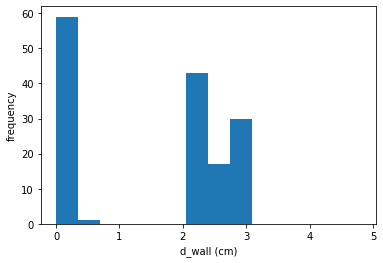

In [5]:
quantity = 'd_wall'
unit = 'cm'
bins = np.linspace(0,tank.r_cm,15)

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.show()

### Velocity

/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


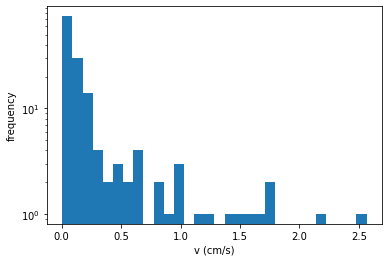

In [6]:
quantity = 'v'
unit = 'cm/s'
bins = 30

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [7]:
# fast = df.loc[:,(slice(None),'v')]>6
# print(np.nonzero(fast.values))
# display(df.iloc[266:269][4])

### Angular velocity

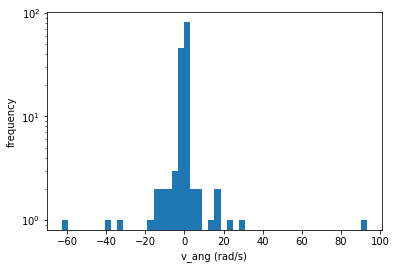

In [8]:
quantity = 'v_ang'
unit = 'rad/s'
bins = 50

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [9]:
# At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# corresponds to about pi/3 in one frame.
print('v_ang for pi/3 in (1/30) second:',np.pi/3*fps)

print('Instances of unusually high v_ang:')
for f in fish:
    ang_diff  = df[f,'ang'].diff()
    ang_diff -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
    for i in I:
        display(df[f,'ang'][i-1:i+2])

v_ang for pi/3 in (1/30) second: 31.415926535897928
Instances of unusually high v_ang:


/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


frame
146    1.054505
147    5.252119
148    5.379137
Name: (0, ang), dtype: float64

frame
150    5.506404
151    8.613955
Name: (0, ang), dtype: float64

frame
123   -1.019837
124   -2.151252
125   -1.139379
Name: (4, ang), dtype: float64

frame
124   -2.151252
125   -1.139379
126   -1.323827
Name: (4, ang), dtype: float64

frame
141   -1.148209
142   -2.495257
143   -2.992477
Name: (4, ang), dtype: float64

### Pair distance-pair angle distribution

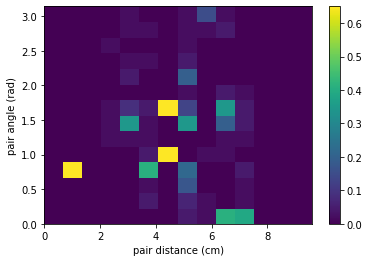

In [27]:
bins_d = np.linspace(0,2*tank.r_cm,15)
bins_a = np.linspace(0,np.pi,15)
H      = [] # np.zeros((len(bins_d)-1,len(bins_a)-1))
for f1,f2 in itertools.combinations(fish,2):
#     print(f1,f2)
    d = np.hypot(df[f1,'x']-df[f2,'x'],df[f1,'y']-df[f2,'y'])
    a = df[f1,'ang']-df[f2,'ang']
    a = np.absolute(a - 2*np.pi*np.rint(a/(2*np.pi)))
    h,_,_ = np.histogram2d(d,a,bins=(bins_d,bins_a),normed=True)
    H.append(h)

H   = np.mean(H,axis=0)
plt.pcolormesh(bins_d,bins_a,H.T)
plt.xlabel('pair distance (cm)')
plt.ylabel('pair angle (rad)')
plt.colorbar()
plt.show()

# Angular dynamics

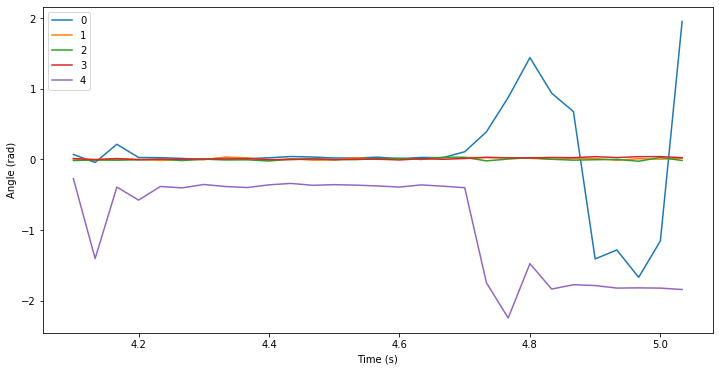

In [28]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

plt.figure(figsize=(12,6))
for f in fish:

    ang  = df[f,'ang']
    t    = ang.index/fps
    
    dang = ang.diff()
    dang = dang - 2*np.pi*np.rint(dang/(2*np.pi))
    ang  = np.cumsum(dang)

#     I = (t>297) & (t<301)
#     t,th = t[I],th[I]

    plt.plot(t,ang,label=f) #,marker='.')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
# plt.savefig(trial.make_fig_file('angle-vs-time',''),**trial.plot_options)
plt.legend()
plt.show()